<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Decision trees</center></h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# First of all..
Let's finish previous seminar super fast!

# Now, Decision Trees!

## Imputiry functions

* Lets recall main imputiry functions for classification

In [2]:
np.random.randint(1,25)

13

* Considering wine dataset from the intoductory seminar\assignment implement
    * impurity function (pick whichever you like)
    * gain calculation

In [17]:
def impurity_measure(p):
    '''
    function outputs a value of impurity function given an array with classes probabilities
    
    p: numpy array with classes probabilities
    '''
    
    impurity = 1 - p.max()
    
    return impurity

def wine_demo():
    # Data
    df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

    # Drawing
    fig, ax = plt.subplots(1, 2)

    fig.set_figheight(5)

    # Change to classification
    df_wine.loc[:, 'quality_cat'] = (df_wine.loc[:, 'quality'] > 5).astype(int) 
    idx = df_wine.loc[:, 'quality_cat'] == 1
    df_wine.loc[idx, 'alcohol'].hist(label='good quality', bins=20, alpha = 0.4, ax=ax[0])
    df_wine.loc[~idx, 'alcohol'].hist(label='bad quality', bins=20, alpha = 0.4, ax=ax[0])
    ax[0].set_xlabel('alcohol')
    
    # 
    p = np.array([df_wine.quality_cat.mean(), 1-df_wine.quality_cat.mean()])
    n = df_wine.shape[0] * 1.0

    init_impurity = impurity_measure(p)
    
    # Raw threshold search
    t_range = np.linspace(df_wine.alcohol.min(), df_wine.alcohol.max(), 100)

    # G is a list with Gains for each threshold
    G = []

    for t in t_range:
        idx = df_wine.alcohol < t
        n1 = idx.sum()
        n2 = (~idx).sum()
        p1 = np.array([df_wine.loc[idx, 'quality_cat'].mean(), 1-df_wine.loc[idx, 'quality_cat'].mean()])
        p2 = np.array([df_wine.loc[~idx, 'quality_cat'].mean(), 1-df_wine.loc[~idx, 'quality_cat'].mean()])
        
        current_gain = init_impurity - ((n1/n) * impurity_measure(p1) + (n2/n) * impurity_measure(p2))
        G.append(current_gain)
        

    ax[1].plot(t_range, G)
    ax[1].set_xlabel('alcohol')
    ax[1].set_ylabel('Gain')

    mG = np.nanmax(G)
    mt = t_range[np.nanargmax(G)]

    ax[0].vlines(mt, 0, 150, label='best threshold (%.2f)' % mt)
    ax[1].vlines(mt, 0, mG, label='best threshold\n(gain = %.4f)' % mG)
    
    ax[0].legend()
    ax[1].legend()

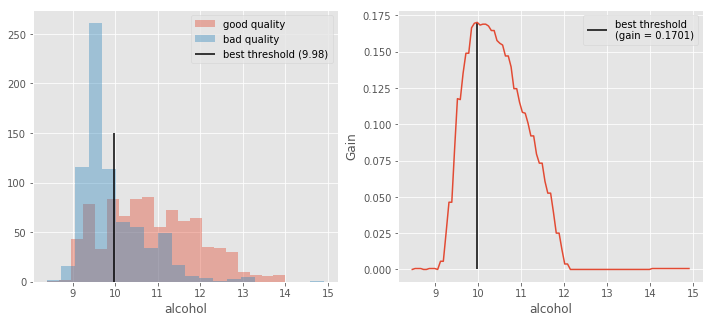

In [18]:
wine_demo()

# Some data

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import subprocess

* Load titanic [dataset](https://cloud.mail.ru/public/N1Tn/25zEKkqge)

In [20]:
df = pd.read_csv('titanic.csv')

In [21]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

* Analyse features and target variable
    * Type of features
    * Any missing values?
    * Class proportions

In [23]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

* Preprocess dataset
    * remove useless features
    * do something with missing values
    * do something with categorical features
    * split into train\test in proportion 80/20

In [37]:
def preproc_dataset(df_input):
    cols_2_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']
    df_input = df_input.drop(cols_2_drop, axis=1)
    
    df_input.loc[:, 'Age'] = df_input.Age.fillna(-999)
    df_input.loc[:, 'Sex'] = df_input.Sex.replace({'male': 0, 'female': 1})
    
    df_input = df_input.dropna()
    
    df_input = pd.get_dummies(df_input, columns=['Embarked'], prefix_sep='=')
    
    return df_input

In [38]:
df_input = df.pipe(preproc_dataset)

In [39]:
df_input.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [42]:
label = 'Survived'
features = df_input.columns != label

In [43]:
features

array([False,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [44]:
X, y = df_input.loc[:, features].values, df_input.loc[:, label].values

In [45]:
X.shape

(889, 9)

In [46]:
y.shape

(889,)

 * Build any tree model and visualize it
 * Show feature importances

In [56]:
model = DecisionTreeClassifier()

model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
def plot_tree(tree, feature_names=None, class_names=['0', '1']):
    with open('tree.dot', 'w') as fout:
        export_graphviz(tree, out_file=fout, feature_names=feature_names, class_names=class_names)
    command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
    subprocess.check_call(command)
    plt.imshow(plt.imread('tree.png'))
    plt.axis("off")


In [58]:
feature_names = df_input.columns[features].values

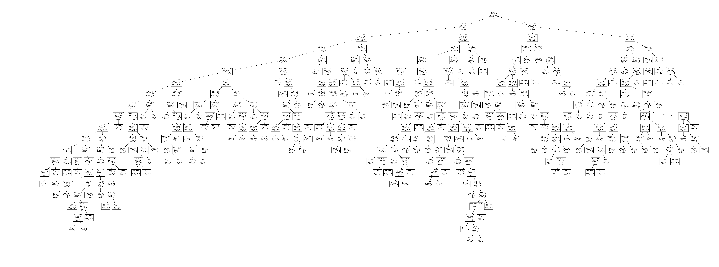

In [59]:
plot_tree(model, feature_names)

In [52]:
!head tree.dot

digraph Tree {
node [shape=box] ;
0 [label="Sex <= 0.5\ngini = 0.472\nsamples = 889\nvalue = [549, 340]\nclass = 0"] ;
1 [label="Fare <= 26.269\ngini = 0.306\nsamples = 577\nvalue = [468, 109]\nclass = 0"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Parch <= 0.5\ngini = 0.226\nsamples = 415\nvalue = [361, 54]\nclass = 0"] ;
1 -> 2 ;
3 [label="gini = 0.184\nsamples = 380\nvalue = [341, 39]\nclass = 0"] ;
2 -> 3 ;
4 [label="gini = 0.49\nsamples = 35\nvalue = [20, 15]\nclass = 0"] ;


In [60]:
imp = pd.Series(index=feature_names, data=model.feature_importances_)

In [61]:
imp.sort_values()

Embarked=Q    0.007192
Embarked=C    0.010110
Embarked=S    0.011441
SibSp         0.041798
Parch         0.043873
Pclass        0.085219
Age           0.208904
Fare          0.284083
Sex           0.307380
dtype: float64

* Using validation curve choose the best value for `max_depth` parameter

In [ ]:
from sklearn.cross_validation import cross_val_score
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

* Now, consider other parameters of the model
* Run grid-search or randomized search of the optimal hyperparameter setting
* Check model quality on test set

In [ ]:
from scipy.stats import randint as randint
from scipy.stats import uniform
try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV


RND_SEED = 123

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [ ]:
param_grid = {
    'max_depth': randint(2, 8),
    'class_weight': [None, 'balanced']
}